<a href="https://colab.research.google.com/github/claudia-viaro/optimal_stopping-switching/blob/main/optimal_switching/opt_switching_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Suppose we fix the final regime of the process

#Problem Formulation
Let $(\Omega, \mathcal{F}, P)$ be a fixed probability space on which an adapted stochastic process is defined $X=(X_t)_{0 \leq t \leq T}$ whose natural filtration is $(\mathcal{F}_t^0 := \sigma \{ X_s, s \leq t \})_{0 \leq t \leq T}$. Let $\mathbf{F}=(\mathcal{F}_0)_{0 \leq t \leq t}$ be the complete filtration of $(\mathcal{F}_t^0 := \sigma \{ X_s, s \leq t \})_{0 \leq t \leq T}$. with $P$-null sets of $\mathcal{F}$.

The stochastic process $X$ is $\mathbb{R}^d$-valued and represents the market price of $d$ financial assets (Bermudan call options) that influence the production of power. Assume $(X^i)_{i=1}^d$ follows a geometric Brownian motion satisfying the SDE:
\begin{equation}
dX_t = b_{I_t}X_tdt + \sigma_{I_t}X_tdW_t
\end{equation}
where $W$ is a standard Brownian motion on a filtered probability space $(\Omega, \mathcal{F}, \mathbf{F}=(\mathcal{F}_t)_{t \geq 0} P)$ and $I_t$ is the indicator variable of the regimes valued in $\mathbf{I}_d = \{1, \ldots, d \}$. $b_i \in \mathbf{R}$ and $\sigma_i >0$ are the drift and volatility of the system $X$ once in regime $I_t=i$ at time $t$.

We will consider a discrete approximization (Euler schema) with respect to. For $i = 1, \ldots, d$ we simulate $p$ paths
\begin{equation}
X^p_{n,i} = \exp \Big\{ \sum_{k=0}^n \big( (b-\sigma^2_i /2)_{\mathbf{I}}\Delta t + \sigma_{i, \mathbf{I}} \sqrt{\Delta t} \cdot Z_{k, i}^p \big)     \Big\}
\end{equation}
where $\Delta t = T/N$ and $Z_{k, i}^{p} \sim \mathcal{N} (0,1)$.



In [33]:
import numpy as np
import torch
import torch.nn as nn
np.random.seed(234198)
import itertools
import random
import time
import scipy.stats

import math
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as tdata

In [34]:
class BlackScholes:
  def __init__(self, drift, sigma, delta, spot, assets,  paths, periods,
         maturity, strike, dividend=0):

    self.drift = drift - dividend
    self.sigma = sigma
    self.delta = delta
    self.spot = spot
    self.assets = assets
    self.paths = paths
    self.periods = periods
    self.maturity = maturity
    self.strike = strike
    self.dt = self.maturity / self.periods
    self.df = math.exp(-self.drift * self.dt)

  def drift_fct(self, x, t):
    del t
    return self.drift * x

  def diffusion_fct(self, x, t, v=0):
    del t
    return self.sigma * x



  def simulate_process(self):
    """Returns a nparray (nb_paths * assets * nb_dates) with prices."""
    paths = self.paths
    spot_paths = np.empty((self.periods+1, paths, self.assets ))

    spot_paths[0, :, :] = self.spot
    random_numbers = np.random.normal(0, 1, (self.periods, paths, self.assets ))
    dW = random_numbers * np.sqrt(self.dt)
    drift = self.drift
    r = np.repeat(np.repeat(np.repeat(
        np.reshape(drift, (-1, 1, 1)), self.periods, axis=0),
        paths, axis=1), self.assets, axis=2)
    sig = np.ones((self.periods, paths, self.assets))*self.sigma
    
    spot_paths[1:, :,  :] = np.repeat(
        spot_paths[0:1, :, :], self.periods, axis=0)* np.exp(np.cumsum((r-self.delta) * self.dt - (sig ** 2) * self.dt / 2 + sig * dW, axis=0))

    return spot_paths #.reshape(spot_paths.shape[2], spot_paths.shape[0], spot_paths.shape[1])


'''
PLOT
'''

def draw_stock_model(stockmodel):
    stock_paths = stockmodel

    # draw a path
    one_path = stock_paths[:, 0, 0]
    dates = np.array([i for i in range(len(one_path))])
    plt.plot(dates, one_path, label='stock path')
    plt.ylabel('Stock price')
    plt.ylabel('Time')
    plt.legend()
    return plt.show()

We employ a neural network to approximate the stopping decision functions $\{f_n\}_{n=0}^N$ by constructing a sequence of neural networks of the form $f^{\theta_n}:\mathbb{R}^d → \{0,1\}$ with parameters $\theta_n \in \mathbb{R}^q$ to approximate $f_n$.


In its basic form, a neural network is composed of several layers, and layers are made of nodes. From the picture below, we can observe that a node combines input from the data, $x_{1:n}$, with a set of weights, $w_{1:n}$, that either amplify or dampen that input, thereby assigning significance to inputs with regard to the task the algorithm is trying to learn. $x_{1:n}$ are either the inputs of the overall network if this node is in the first layer or the outputs from the previous layer. Then, the input-weight products are summed, usually with a bias term, and the sum is passed through a node’s so-called activation function $f$, to determine whether and to what extent that signal should progress further through the network to affect the ultimate outcome (depending on the magnitude of each associated weight $w_i$). If the signals passes through, we can say that the neuron has been “activated” and returns an output.


![](https://drive.google.com/uc?export=view&id=1rButBJka1QjKsLSrAWgJKrxNCGdntf-K)

Generally, NNs comprise multiple node layers through which data is passed, giving rise to what can be referred to as the depth of a neural network. In such networks, each layer of nodes trains on a distinct set of features based on the previous layer’s output. The further we move into the neural net, the more complex the features can be recognized by the nodes, since they aggregate and recombine features from the previous layer.

![](https://drive.google.com/uc?export=view&id=1b8Hbzn5xahE9jHf5jgIslG3dedkLAHst)

The neural network used here takes the form $F^{\theta}: \mathbb{R}^d → (0,1)$ for $\theta \in \{\theta_0, \ldots, \theta_N  \}$, that is the parameters are trained via a neural network that outputs probabilities in the interval $(0,1)$. This is due to the fact that the G-B optimization algorithm is to be applied to a continuous function with respect to $\theta_n$, which $f^{\theta_n}$ is not. Hence, the multi-layer, feed-forward neural network takes the form:

\begin{equation}
F^{\theta}= \psi \circ a_3^{\theta} \circ \phi_{q_2} \circ a_2^{\theta} \circ \phi_{q_1} \circ a_1^{\theta}
\end{equation}
where 

-  $q_1, q_2$ are the number of nodes in the hidden layers
- $a_1^{\theta} : \mathbb{R}^d → \mathbb{R}^{q_1}, a_2^{\theta}: \mathbb{R}^{q_1} → \mathbb{R}^{q_2}$ are linear transformation functions: $a_i^{\theta}(x)=W_i x + b_i$ with matrices $W_1 \in \mathbb{R}^{q_1 \times d}, W_2 \in \mathbb{R}^{q_2 \times q_1}, W_3 \in \mathbb{R}^{q_2 \times 1}$ and vectors $b_1 \in \mathbb{R}^{q_1}, b_2 \in \mathbb{R}^{q_2}, b_3 \in \mathbb{R}^{1}$.
- $\phi_{q_i}: \mathbb{R}^{q_i}$ is the ReLU activation function: $\phi_{q_1}(x_i, \ldots, x_{q_i})=(x_i^{+}, \ldots, x_{q_i}^{+})$
- $\psi = \mathbb{R} → \mathbb{R}$ is the logistic sigmoid function: $\psi(x)=1/(1+ e^{-x})$.
Between the layers a batch normalization is also added, it takes the output from the previous layer and normalizes it before sending it to the next layer. This has the effect of stabilizing the neural network. 

The parameters will comprise $\theta = \{W_1, W_2,, W_3, b_1, b_2, b_3\}\in \mathbb{R}^q$, where $q=q_1(d+q_2+1)+2q_2+1$. The value of $d$ stands for the dimension, that is the number of assets and will be varied among $d=\{2,4, 5, 10, 20\}. 





In [35]:
class Ftheta_NN(nn.Module):
  def __init__(self, assets):
    super(Ftheta_NN, self).__init__()
    H = assets + 40
    self.bn0 = nn.BatchNorm1d(num_features=assets)
    self.a1 = nn.Linear(assets, H)
    self.relu = nn.ReLU()
    self.bn1 = nn.BatchNorm1d(num_features=H)
    self.a2 = nn.Linear(H, H)
    self.bn2 = nn.BatchNorm1d(num_features=H)
    self.a3 = nn.Linear(H, 1)
    self.bn3 = nn.BatchNorm1d(num_features=1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input):
    out = self.bn0(input)
    out = self.a1(out)

    out = self.relu(out)
    out = self.bn1(out)

    #out = self.a2(out)
    
    #out = self.relu(out)
    #out = self.bn2(out)
    out = self.a3(out)
    
    out = self.sigmoid(out)
    return out

# set initial weights of a linear layer of the NN with uniform values and bias=0.01 (or choose zero initial weights)
def init_weights(m):
  if isinstance(m, torch.nn.Linear):
    torch.manual_seed(42)
    #torch.nn.init.zeros_(m.weight)
    torch.nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)

In [36]:
class Training_network(object):

  def __init__(self, assets, epochs = 400, batch_size=2000):
    self.assets = assets
    self.epochs = epochs
    self.batch_size = batch_size
    self.network = Ftheta_NN(self.assets).double()
    self.network.apply(init_weights)


  def train_network(self,  stock_values, current_payoff,
                    future_payoff):
    optimizer = optim.Adam(self.network.parameters())
    
    # transform data into tensors 
    future_payoff = torch.from_numpy(future_payoff).double()
    current_payoff = torch.from_numpy(current_payoff).double()
    X_inputs = torch.from_numpy(stock_values).double()

    self.network.train(True)
    ones = torch.ones(len(future_payoff))
    losses = []

    for epoch in range(self.epochs):
      running_loss = 0.0

      for batch in tdata.BatchSampler(
              tdata.RandomSampler(range(len(X_inputs)), replacement=False),
              batch_size=self.batch_size, drop_last=False):
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
          outputs = self.network.forward(X_inputs[batch]).reshape(-1) 
          reward = (current_payoff[batch].reshape(-1) * outputs + future_payoff[batch] * (ones[batch] - outputs) )

          # compute loss function
          loss = -torch.mean(reward)

          # compute gradients and backpropagate
          loss.backward() 

          # take a step, updating the parameters  
          optimizer.step() 

          running_loss += loss.item() * self.batch_size
      epoch_loss = running_loss /  len(tdata.BatchSampler(
              tdata.RandomSampler(range(len(X_inputs)), replacement=False),
              batch_size=self.batch_size, drop_last=False).sampler)
      losses.append(epoch_loss)


    torch.save(self.network.state_dict(), 'checkpoint.pth')
    return outputs, self.network, losses  

  def evaluate_network(self, X_inputs):

    # load saved optimized parameters
    state_dict = torch.load('checkpoint.pth')
    
    # impose "evaluation" mode
    self.network.eval()
    X_inputs = torch.from_numpy(X_inputs).double()
    outputs = self.network(X_inputs)
    return outputs.view(X_inputs.size()).detach().numpy(), self.network

# Class "Profit"
This class contains various payoff and costs elements that define the reward. The final profit value is computed for each date and path.

### terminal reward
The terminal function $\Gamma_T$ is set to an option payoff function of choice regardless of the regime in which the process is at, in this case we have a Max Call. (other choices can be made as well). The terminal payoff is received at maturity, with no other costs nor payoffs.
\begin{equation}
\Gamma(T) = \Big(\max_{d \in \{1, \ldots, D \}} x^d - K   \Big)^{+} \tag{1}
\end{equation}

### running reward
The function $\Psi_i = (\Psi_i(t))_{n \in \mathbb{N}}$ represents the running reward received while in mode $q \in \mathbb{I}$. 
\begin{equation}
\Psi_i(t) = \Big[\Big(\max_{d \in \{1, \ldots, D\}} x^d - K   \Big)^{+} \Big] \tag{2}
\end{equation}

### switching cost
The function $\gamma_{i, j} = (\gamma_{i, j}(t))_{t \in \mathbb{T}}$ with $i,j \in \mathbb{I} = \{0, 1 \}$ represents the cost for switching from mode $i \in \mathbb{I}$ to mode $j \in \mathbb{I}$.
\begin{equation} \tag{3}
\gamma_{0,0} \equiv \gamma_{1,1} \equiv 0 \\
\gamma_{0,1}(t) = \Big(\max_{d \in \{1, \ldots, D \}} x^d - K   \Big)^{+} + \delta  \;\;\;\;\; \delta \sim \mathcal{N}(0,1)   \\ 
\gamma_{1, 0}(t) = - \Big(\max_{d \in \{1, \ldots, D \}} x^d - K   \Big)^{+} 
\end{equation}

### the full expression for the profit
The entire expression for the value of the process at each time $n$ can be represented as: 
\begin{equation} \tag{4}
\tilde{Y}_{T}^i = \Gamma \mathbf{1}_{\{\tau = T\}} 
\end{equation}

\begin{equation}
\begin{aligned}
\tilde{Y}_{t}^i &= - \gamma_{i, j}(\tau) + \Psi_i(\tau) + \mathbb{E}[\tilde{Y}_{t+1}^i | \mathcal{F}_t] \;\;\;\;\; \text{if } i \neq j \text{,   for    } t=T-1, \ldots, 0 \\
&= \Psi_i(\tau) + \mathbb{E}[\tilde{Y}_{t+1}^i | \mathcal{F}_t]  \;\;\;\;\; \text{if } i = j \text{,   for    } t=T-1, \ldots, 0
\end{aligned}
\end{equation}

In [37]:
class Profit_training:
  def __init__(self, model):
    self.strike = model.strike
    self.model = model
    

  def terminal(self, X):
    payoff = np.max(X, axis=1) - self.strike
    return payoff.clip(0, None)

  def g(self, date,path,X):
    max1=np.max(X[int(date) , path , : ]-self.strike)
    return np.exp(-self.model.drift*self.model.dt*date)*np.max(max1,0) 
 

  def running(self, Y, X):
    gamma = np.array([self.terminal(X) + 0.7, -self.terminal(X)]) # there are two rows, the first for \gamma_{0,1}, the second for \gamma_{1,0}
    r_benefit = self.terminal(X)
    return r_benefit+Y-gamma 
 
class Profit_testing:
  def __init__(self, model):
    self.strike = model.strike
    self.model = model

  def terminal(self, X):
    payoff = np.max(X, axis=1) - self.strike
    return payoff.clip(0, None)  

  def g(self, date,path,X):
    max1=np.max(X[date , path , : ]-self.strike)
    return np.max(max1,0) 


  # switch is F_theta_train 
  def running(self, Y, date, path, S, X, switch, gamma):
    val=Y[date+1, path]- gamma  
    k = np.array([0.4, 0.7])
    r_benefit = self.g(date, path, X)
    return val*int(switch[date, path])+r_benefit.numpy()


  def current_payoff(self, data, Y, date, regimes, regimepath):
    current_p = np.zeros((self.model.paths))
    
    for m in range(0, self.model.paths - 1):
        value = Y[date+1, m]
        running_benefit = self.g(date, m, data)      
        old_regime = int(regimepath[date +1, m])     
        current_regime = int(regimes[~old_regime])

        
        if (old_regime - current_regime)>0:          #gamma 0-1
          gamma = self.g(date, m, data)**0.3+np.random.normal(0,1,1) + value
        
        else: gamma = - self.g(date, m, data) + value #gamma 1-0  
        current_p[m] = gamma + running_benefit
        #current_p[m] = gamma + running_benefit
            
    return current_p

  def current_payoff_trained(self, data, Y, date, regimes, regime_path, which): 
    current_p = np.zeros((self.model.paths))
    for m in range(0, self.model.paths - 1):
      running_benefit = self.g(date, m, data) 
      old_regime = int(regime_path[date +1, m])
      value = Y[date+1, m]
      
      if int(which[m])==1:
        regime_path[date, m] = regimes[~old_regime]
        current_regime = regime_path[date, m]
        if (old_regime - current_regime)>0:          
          gamma = self.g(date, m, data)**0.3+np.random.normal(0,1,1) + value #gamma 0-1
        else: 
          gamma = - self.g(date, m, data) + value #gamma 1-0  
      else:
        regime_path[date, m]=int(regimes[~old_regime])
        gamma = 0
      current_p[m] = gamma + running_benefit
    return current_p
    

In [38]:
class Training:
  def __init__(self, model, payoff):

    self.model = model    
    self.neural_stopping = Training_network(self.model.assets, 400) 
    self.payoff = Profit_testing(self.model)

  def value(self):
    model = self.model
    stock_paths = self.model.simulate_process()    
    
    # create empty objects to store values
    regimes = [0, 1]
    regime_path=np.zeros((model.periods+1, model.paths)) # record at which regime we're at at each n
    Y_train=np.zeros((model.periods+1, model.paths))
    F_theta_train=np.zeros((model.periods+1,model.paths)) # record switching events for each n
    mods=[None]*model.periods # record the models of the NN for testing
    loss_functions = [None]*model.periods

    # at maturity N
    final_payoff = self.payoff.terminal(stock_paths[-1, :, :])   # payoff of the last date for each path.
    Y_train[model.periods, :]= final_payoff
    F_theta_train[model.periods,:]=1 # at maturity we switch 
    regime_path[model.periods, :] = random.sample(regimes, 1)[0] # sample a regime at maturity
    values = final_payoff
    print("date", model.periods, ",", model.paths)

    # before maturity
    for date in range(stock_paths.shape[0] - 2, 0, -1): 
      current_payoff = self.payoff.current_payoff(data = stock_paths, 
                                               Y = Y_train, date = date, 
                                               regimes = regimes,
                                               regimepath = regime_path)

      stopping_probability, networks, loss = self.neural_stopping.train_network(stock_paths[date, : , :], 
                                                    current_payoff, 
                                                    final_payoff*(np.math.exp((-model.drift) * (model.periods-date)/model.periods)))

      
      
      print("date", date, ",", len([1 for l in stopping_probability if l > 0.5]), " mean loss ", np.mean(loss))
      F_theta_train[date,:]=(stopping_probability > 0.5)*1.0   # transform stopping probabilities in 0-1 decision
      which = stopping_probability > 0.5
      immediate_exercise_value = self.payoff.current_payoff_trained(stock_paths, Y_train, date, regimes, regime_path, which)


      values[which] = immediate_exercise_value[which] # when we switch we take the current profit
      values[~which] *= np.math.exp((-model.drift) * ((model.periods-date)/model.periods))           # when we don't switch we take final profit discounted 
      Y_train[date, :] = values

      mods[date]=networks 
      loss_functions[date]=loss    
    
    return mods, loss_functions


    

  def stop(self, stock_values, current_payoff,
           future_payoff):
    
    self.neural_stopping.train_network(
      stock_values,
      current_payoff ,
      future_payoff)

    inputs = stock_values
    stopping_probability , networks   = self.neural_stopping.evaluate_network(inputs)
    return stopping_probability , networks  


In [39]:
# simulate paths Y
# goal of this phase is to be able to get stopping decisions f_theta_n
hyperparam_training = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1,  'paths':200, 'periods': 9, 'maturity': 3., 'strike' : 100,'assets':2,  'spot':90,}
S_train=BlackScholes(**hyperparam_training)


pricing = Training(S_train, Profit_testing)
'''
arguments are:
- path process
- Profit testing classes


'''

mods, functions = pricing.value()


date 9 , 200
date 8 , 186  mean loss  -493.1139946334242
date 7 , 196  mean loss  -506.75732664416296


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars


date 6 , 0  mean loss  nan
date 5 , 0  mean loss  nan
date 4 , 0  mean loss  nan
date 3 , 0  mean loss  nan
date 2 , 0  mean loss  nan
date 1 , 0  mean loss  nan


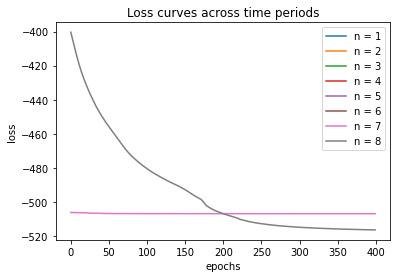

In [40]:
filtered_list = list(filter(None, functions))
legend = ["n = 1", "n = 2", "n = 3", "n = 4", "n = 5", "n = 6", "n = 7", "n = 8"]

for i in range(len(filtered_list)):
  epochs = np.array([i for i in range(len(filtered_list[0]))])
  plt.plot(epochs, filtered_list[i], label='loss funciton')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(legend)
  plt.title('Loss curves across time periods')
  plt.plot()

#Lower bound

the stopping time $\tau^{\Theta}$ gives a lower bound $L=\mathbb{E}g(\tau^{\Theta}, X_{\tau^{\Theta}})$ for the optimal value $V_0= \sup_{\tau \in \mathcal{T}}\mathbb{E}g(\tau, X_{\tau})$.

Simulate 
- $K_L = 1024$ paths $(y_n^k)_{n=0}^N$, $k=1, \ldots, K_L$, of $(X_n)_{n=0}^N$ and assume these are drawn independently from the realizations $(x_n^k)_{n=0}^N$, $k=1, \ldots, K$.

The unbiased estimate of the lower bound $L$ is given by
\begin{equation}
\hat{L}=\frac{1}{K_L} \sum_{k=1}^{K_L} g(l^k, y_{l^k}^k)
\end{equation}
where $l^k = l(y_0^k, \ldots, y_{N-1}^k)$

In [ ]:
# Testing phase - Lower bound

# sample y from the process (Y)
hyperparam_testing_L = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1,  'paths':5000, 'periods': 9, 'maturity': 3., 'strike' : 100,'assets':20,  'spot':110,}
S_test_L=BlackScholes(**hyperparam_testing_L)

# now we can compute all the stopping times recursively

In [ ]:
# Testing

class Testing_Lower:
  def __init__(self, model, training, testing, mods):   
    self.model = model # argument is S   
    self.neural_stopping = Training_network(model.assets, 400) 
    self.profit_testing = Profit_testing(self.model)
    self.mods = mods

  def price(self):
    model = self.model
    disc_factor = np.math.exp((-model.drift) * model.maturity/(model.periods))
    stock_paths = self.model.simulate_process()
    k = np.array([0.4, 0.7])
    regimes = [0, 1]
    regime_path=np.zeros((model.periods+1, model.paths)) # record at which regime we're at at each n
    Y_train=np.zeros((model.periods+1, model.paths))
    F_theta_train=np.zeros((model.periods+1,model.paths)) # record switching events for each n
 
    # at maturity N
    final_payoff = np.array([self.profit_training.terminal(stock_paths[-1, :, :]), self.profit_training.terminal(stock_paths[-1, :, :])])   # payoff of the last date for each path.
    future_payoff = torch.from_numpy(final_payoff*(np.math.exp((-model.drift) * model.periods))).double() 
    Y_train[model.periods, :]= final_payoff[0]
    F_theta_train[model.periods,:]=1 # at maturity we switch (does it matter?)
    regime_path[model.periods, :] = random.sample(regimes, 1)[0] # sample a regime at maturity
    values = Y_train[model.periods, :]


    


    # recursive calc. before maturity
         
    for date in range(stock_paths.shape[0] - 2, 0, -1):
      current_payoff = self.profit_training.running(Y_train[date+1, :], stock_paths[date, :, :])
      mod_curr=self.mods[date]
      probs=mod_curr(torch.from_numpy(stock_paths[date])) 
      np_probs=probs.detach().numpy().reshape(self.model.paths)
      
      F_theta_train[date,:]=(np_probs > 0.5)*1.0   # transform stopping probabilities in 0-1 decision
      which = np_probs > 0.5

      for m in range(0,model.paths-1):
        old_regime = regime_path[date +1, m]
        regime_path[date, m] = int(which[m])
        if which[m] == True:
          if int(old_regime) - int(which[m])>0:  #gamma 0-1
            gamma = self.profit_testing.g(date, m, stock_paths)+0.7
          else: gamma = -self.profit_testing.g(date, m, stock_paths) #gamma 1-0  
        else:
          gamma = 0 
        Y_train[date, m] = Y_train[date+1, m]- gamma


      immediate_exercise_value = Y_train[date, :]       
      values[which] = immediate_exercise_value[which] # when we switch we take the current profit
      values[~which] *= ((model.periods-date)/model.periods)           # when we don't switch we take final profit discounted 

      #Y_train[date, :] = values
      print("date", date, round(np.mean(values), 3), len([1 for l in np_probs if l > 0.5]))

    
    return round(np.mean(values), 3), Y_train



In [ ]:


dict ={}
 
# Insert data into dictionary
dict1 = {
     1: ["2", 90, 97.339, 0.009],
     2: ["2", 100, 205.426, 0.006],
     3: ["2", 110, 315.878, 0.007],
     7: ["4", 90, 130.082, 0.008],
     8: ["4", 100, 235.951, 0.008],
     9: ["4", 110, 334.079, 0.005],
     10: ["5", 90, 134.486, 0.008],
     11: ["5", 100, 224.051, 0.006],
     12: ["5", 110, 282.737, 0.006],
     13: ["10", 90, 158.875, 0.005],
     14: ["10", 100, 273.452, 0.008],
     15: ["10", 110, 391.043, 0.015],
     16: ["20", 90, 100.447, 0.008],
     17: ["20", 100, 192.448, 0.01],
     18: ["20", 110, 301.107, 0.009],
     }
 
# Print the names of the columns.
print ("{:<10} {:<10} {:<10} {:<10}".format('assets', 'spot', 'L', 'timeL'))
 
# print each data item.
for key, value in dict1.items():
    assets, spot, L, timeL = value
    print ("{:<10} {:<10} {:<10} {:<10}".format(assets, spot, L, timeL))